# Mnist DataScience (Training Stage)

In [4]:
from scanflow.tools import env
print(env.get_env("SCANFLOW_CONTROLLER_URI"))
print(env.get_env("SCANFLOW_TRACKER_URI"))
# print(env.get_env("SCANFLOW_TRACKER_LOCAL_URI"))

http://172.30.0.50:46666
http://172.30.0.50:46667


In [6]:
import sys
import matplotlib.pyplot as plt
import os
sys.path.insert(0,'../..')

import scanflow
from scanflow.client import ScanflowClient
from scanflow.client import ScanflowTrackerClient

# App folder
base_path = os.path.dirname(os.getcwd())
app_dir = os.path.join(base_path, "examples/mnist/datascience")
app_name = "mnist"
team_name = "datascience"

# scanflow client
client = ScanflowClient(scanflow_controller_uri="http://172.30.0.50:46666",
                        verbose=True)
trackerClient = ScanflowTrackerClient(scanflow_tracker_uri="http://172.30.0.50:46667",
                        verbose=True)

## 1. Develop scanflow application (local)

  1. develop component (requirement.txt, script.py)
  2. define scanflow application (Executor, Dependency, Workflow, Application)
  ```bash
     Application
        - List: Workflow(DAG)
                  - List: Executor
                  - List: Dependency
  ```


In [3]:
executor1 = client.ScanflowExecutor(name='load_data', 
                      mainfile='loaddata.py',
                      parameters={'app_name': app_name,
                                  'team_name': 'data'},
                      requirements='req_loaddata.txt')

executor2 = client.ScanflowExecutor(name='modeling_cnn', 
                      mainfile='modeling.py',
                      parameters={'x_train_path': './data/mnist/train_images.npy', 
                                  'y_train_path': './data/mnist/train_labels.npy',
                                  'x_test_path': './data/mnist/test_images.npy',
                                  'y_test_path': './data/mnist/test_labels.npy'},
                      requirements='req_modeling.txt')

executor3 = client.ScanflowExecutor(name='modeling_cnn1', 
                      mainfile='modeling.py',
                      parameters={'x_train_path': './data/mnist/train_images.npy', 
                                  'y_train_path': './data/mnist/train_labels.npy',
                                  'x_test_path': './data/mnist/test_images.npy',
                                  'y_test_path': './data/mnist/test_labels.npy'},
                      requirements='req_modeling.txt')


executor4 = client.ScanflowExecutor(name='checker', 
                      mainfile='modeling.py',
                      parameters={'x_train_path': './data/mnist/train_images.npy'},
                      requirements='req_modeling.txt')



dependency1 = client.ScanflowDependency(dependee='load_data',
                                    depender='modeling_cnn')

dependency2 = client.ScanflowDependency(dependee='load_data',
                                    depender='modeling_cnn1')

dependency3 = client.ScanflowDependency(dependee='load_data',
                                    depender='checker')

##workflow1 mnist-wf
## -- load_data
##       -- modeling_cnn
##       -- modeling_cnn1
workflow1 = client.ScanflowWorkflow(name='mnist-wf', 
                     executors=[executor1, executor2, executor3],
                     dependencies=[dependency1, dependency2])
##workflow2 mnist-checker-wf
## -- load_data
##    -- checker
workflow2 = client.ScanflowWorkflow(name='mnist-checker-wf', 
                     executors=[executor1, executor4],
                     dependencies=[dependency3])


app = client.ScanflowApplication(app_name = app_name,
                                 app_dir = app_dir,
                                 team_name = team_name,
                                 workflows=[workflow1, workflow2],
                                 verbose=True)
              

In [4]:
dic = app.to_dict()

20-Apr-21 18:33:10 -  INFO - Scanflowapp: {'app_name': 'mnist', 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/tutorials/examples/mnist/datascience', 'team_name': 'datascience', 'workflows': [{'name': 'mnist-wf', 'executors': [{'name': 'load_data', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': 'req_loaddata.txt', 'dockerfile': None, 'env': None}, {'name': 'modeling_cnn', 'mainfile': 'modeling.py', 'parameters': {'x_train_path': './data/mnist/train_images.npy', 'y_train_path': './data/mnist/train_labels.npy', 'x_test_path': './data/mnist/test_images.npy', 'y_test_path': './data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'env': None}, {'name': 'modeling_cnn1', 'mainfile': 'modeling.py', 'parameters': {'x_train_path': './data/mnist/train_images.npy', 'y_train_path': './data/mnist/train_labels.npy', 'x_test_path': './data/mnist/test_images.npy', 'y_test_path': './data/mnist/test_label

  
## 2. Build scanflow application (local build and scanflow-tracker)
   
  1. build images for Executor -> save to image registry
  2. build scanflow-local-tracker image -> save to image registry
  3. build workflow -> save workflow metadata to scanflow-tracker



## 3. Deploy scanflow application (scanflow-controller)
  
  1. deploy scanflow application
        - create namespace
        - deploy scanflow-local-tracker (k8s)
        - run workflows (argo)
            - run workflow1 to train model_cnn
            - run workflow2 to train checker
            
--------------------Team to Evaluate the model-------(if training stage is finished)-------------
  


## 4. Save the prepared model to scanflow-tracker

  1. call scanflow-controller to pull checker model (e.g., drift_detector)
  2. call scanflow-controller server pull model (e.g., mnist_cnn)



## 5. Submit all artifacts to scanflow-tracker
```bash
  mnist
    - workflows
       - load_data
         - loaddata.py
         - req_loaddata.txt
       - modeling_cnn
         - modeling.py
         - req_modeling.txt
       - checker
         - checker.py
         - req_checker.txt
```



  
## 6. Clean environment (scanflow-controller)
  
  1. clean training workflow, delete namespace
  

In [5]:
import json
with open("./workflow", 'w') as fout:
    json.dump(dic,fout,indent=2)
# print(json.dumps(dic, indent=2))

In [22]:
with open("./workflow") as fin:
    data = json.load(fin)
print(data)

{'app_name': 'mnist', 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/tutorials/examples/mnist/datascience', 'workflows': [{'name': 'mnist-wf', 'executors': [{'name': 'load_data', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': 'req_loaddata.txt', 'dockerfile': None, 'env': None}, {'name': 'modeling_cnn', 'mainfile': 'modeling.py', 'parameters': {'x_train_path': './data/mnist/train_images.npy', 'y_train_path': './data/mnist/train_labels.npy', 'x_test_path': './data/mnist/test_images.npy', 'y_test_path': './data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'env': None}, {'name': 'modeling_cnn1', 'mainfile': 'modeling.py', 'parameters': {'x_train_path': './data/mnist/train_images.npy', 'y_train_path': './data/mnist/train_labels.npy', 'x_test_path': './data/mnist/test_images.npy', 'y_test_path': './data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'env'

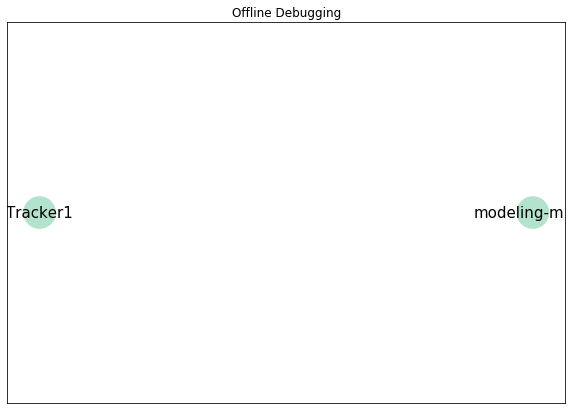

In [9]:
client.drawScanflowApplicationGraph(scanflowapp=app)

In [7]:
# deploy backend
argo = client.get_deploy_backend(setup, 
                  backend="argo", 
                  namespace="mnist-training",
                  registry="172.30.0.49:5000",
                  k8sconfigdir="/gpfs/bsc_home/xpliu/.kube/config")

15-Apr-21 19:32:00 -  INFO - [++]Creating namespace "mnist-training"
15-Apr-21 19:32:00 -  INFO - [++]Creating Role for 'default service account'


In [ ]:
argo.build_workflows()

## Submit All

In [6]:
import json
print(json.dumps(dic, indent=2))

{
  "app_name": "mnist",
  "app_dir": "/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/tutorials/examples/mnist-DS/workflow",
  "workflows": [
    {
      "name": "mnist-wf",
      "executors": [
        {
          "name": "load_data",
          "mainfile": "loaddata.py",
          "parameters": {
            "app_name": "mnist",
            "team_name": "data"
          },
          "requirements": "req_loaddata.txt",
          "dockerfile": null,
          "env": null
        },
        {
          "name": "modeling_cnn",
          "mainfile": "modeling.py",
          "parameters": {
            "x_train_path": "./data/mnist/train_images.npy",
            "y_train_path": "./data/mnist/train_labels.npy",
            "x_test_path": "./data/mnist/test_images.npy",
            "y_test_path": "./data/mnist/test_labels.npy"
          },
          "requirements": "req_modeling.txt",
          "dockerfile": null,
          "env": null
        },
        {
          "name": "modeling_cnn1",